Iterative Self-Organizing Data Analysis Technique (ISODATA) Algorithm

(500, 500, 3)


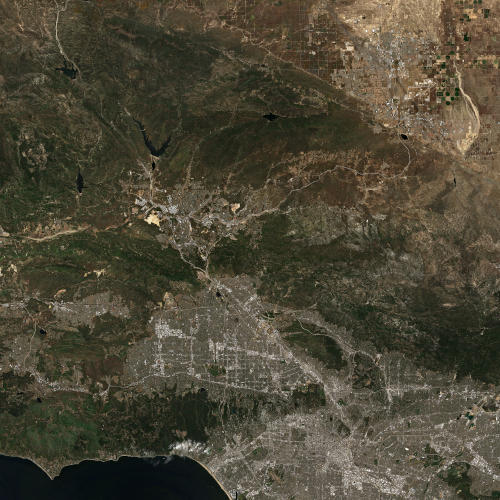

In [ ]:
%matplotlib notebook
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

image = Image.open("data.png")
data = np.array(image)[:, :, :3].astype(np.float) / 255
print(data.shape)
image

In [ ]:
from scipy.cluster import vq



def initialize_parameters(parameters=None):
   
    parameters = {} if not parameters else parameters

    def safe_pull_value(parameters, key, default):
        return parameters.get(key, default)

    # number of clusters desired
    K = safe_pull_value(parameters, 'K', 5)
    
    # maximum number of iterations
    I = safe_pull_value(parameters, 'I', 100)

    # maximum of number of pairs of clusters which can be merged
    P = safe_pull_value(parameters, 'P', 4)

    # threshold value for  minimum number of samples in each cluster
    # (discarding clusters)
    n_min = safe_pull_value(parameters, 'n_min', 10)

    # threshold value for standard deviation (for split)
    Sigma_max = safe_pull_value(parameters, 'Sigma_max', 1)
    # threshold value for pairwise distances (for merge)
    L = safe_pull_value(parameters, 'L', 20)

    # percentage of change in clusters between each iteration
    #(to stop algorithm)
    THETA_O = 0.05

    #can use any of both fixed or random
    # number of starting clusters
    #k = np.random.randint(1, K)
    k = safe_pull_value(parameters, 'k', K)

    ret = locals()
    ret.pop('safe_pull_value')
    ret.pop('parameters')
    globals().update(ret)


def quit_low_change_in_clusters(centers, last_centers, iter):
    """Stop algorithm by low change in the clusters values between each
    iteration.

    :returns: True if should stop, otherwise False.

    """
    quit = False
    if centers.shape == last_centers.shape:
        thresholds = np.abs((centers - last_centers) / (last_centers + 1))

        if np.all(thresholds <= THETA_O):  # percent of change in [0:1]
            quit = True
#            print "Isodata(info): Stopped by low threshold at the centers."
#            print "Iteration step: %s" % iter

    return quit


def merge_clusters(img_class_flat, centers, clusters_list):
    """
    Merge by pair of clusters in 'below_threshold' to form new clusters.
    """
    pair_dists = compute_pairwise_distances(centers)

    first_p_elements = pair_dists[:P]

    below_threshold = [(c1, c2) for d, (c1, c2) in first_p_elements
                                if d < L]

    if below_threshold:
        k = centers.size
        count_per_cluster = np.zeros(k)
        to_add = np.array([])  # new clusters to add
        to_delete = np.array([])  # clusters to delete

        for cluster in range(0, k):
            result = np.where(img_class_flat == clusters_list[cluster])
            indices = result[0]
            count_per_cluster[cluster] = indices.size

        for c1, c2 in below_threshold:
            c1_count = float(count_per_cluster[c1]) + 1
            c2_count = float(count_per_cluster[c2])
            factor = 1.0 / (c1_count + c2_count)
            weight_c1 = c1_count * centers[c1]
            weight_c2 = c2_count * centers[c2]

            value = round(factor * (weight_c1 + weight_c2))

            to_add = np.append(to_add, value)
            to_delete = np.append(to_delete, [c1, c2])

        #delete old clusters and their indices from the availables array
        centers = np.delete(centers, to_delete)
        clusters_list = np.delete(clusters_list, to_delete)

        #generate new indices for the new clusters
        #starting from the max index 'to_add.size' times
        start = int(clusters_list.max())
        end = to_add.size + start

        centers = np.append(centers, to_add)
        clusters_list = np.append(clusters_list, range(start, end))

        centers, clusters_list = sort_arrays_by_first(centers, clusters_list)

    return centers, clusters_list


def compute_pairwise_distances(centers):
    """
    Compute the pairwise distances 'pair_dists', between every two clusters
    centers and returns them sorted.
    Returns:
           - a list with tuples, where every tuple has in it's first coord the
             distance between to clusters, and in the second coord has a tuple,
             with the numbers of the clusters measured.
             Output example:
                [(d1,(cluster_1,cluster_2)),
                                  ...
                 (dn, (cluster_n,cluster_n+1))]
    """
    pair_dists = []
    size = centers.size

    for i in range(0, size):
        for j in range(0, size):
            if i > j:
                d = np.abs(centers[i] - centers[j])
                pair_dists.append((d, (i, j)))

    #return it sorted on the first elem
    return sorted(pair_dists)


def split_clusters(img_flat, img_class_flat, centers, clusters_list):
    """
    Split clusters to form new clusters.
    """
    assert centers.size == clusters_list.size, \
        "ERROR: split() centers and clusters_list size are different"

    delta = 10
    k = centers.size
    count_per_cluster = np.zeros(k)
    stddev = np.array([])

    avg_dists_to_clusters = compute_avg_distance(img_flat, img_class_flat,
                                                 centers, clusters_list)
    d = compute_overall_distance(img_class_flat, avg_dists_to_clusters,
                                 clusters_list)

    # compute all the standard deviation of the clusters
    for cluster in range(0, k):
        indices = np.where(img_class_flat == clusters_list[cluster])[0]
        count_per_cluster[cluster] = indices.size
        value = ((img_flat[indices] - centers[cluster]) ** 2).sum()
        value /= count_per_cluster[cluster]
        value = np.sqrt(value)
        stddev = np.append(stddev, value)

    cluster = stddev.argmax()
    max_stddev = stddev[cluster]
    max_clusters_list = int(clusters_list.max())

    if max_stddev > Sigma_max:
        if avg_dists_to_clusters[cluster] >= d:
            if count_per_cluster[cluster] > (2.0 * n_min):
                old_cluster = centers[cluster]
                new_cluster_1 = old_cluster + delta
                new_cluster_2 = old_cluster - delta

                centers = np.delete(centers, cluster)
                clusters_list = np.delete(clusters_list, cluster)

                centers = np.append(centers, [new_cluster_1, new_cluster_2])
                clusters_list = np.append(clusters_list, [max_clusters_list,
                                          (max_clusters_list + 1)])

                centers, clusters_list = sort_arrays_by_first(centers,
                                                              clusters_list)

                assert centers.size == clusters_list.size, \
                   "ERROR: split() centers and clusters_list size are different"

    return centers, clusters_list


def compute_overall_distance(img_class_flat, avg_dists_to_clusters,
                             clusters_list):
    """
    Computes the overall distance of the samples from their respective cluster
    centers.
    """
    k = avg_dists_to_clusters.size
    total = img_class_flat.size
    count_per_cluster = np.zeros(k)

    for cluster in range(0, k):
        indices = np.where(img_class_flat == clusters_list[cluster])[0]
        count_per_cluster[cluster] = indices.size

    d = ((count_per_cluster / total) * avg_dists_to_clusters).sum()

    return d


def compute_avg_distance(img_flat, img_class_flat, centers, clusters_list):
    """
    Computes all the average distances to the center in each cluster.
    """
    k = centers.size
    avg_dists_to_clusters = np.array([])

    for cluster in range(0, k):
        indices = np.where(img_class_flat == clusters_list[cluster])[0]

        total_per_cluster = indices.size + 1
        sum_per_cluster = (np.abs(img_flat[indices] - centers[cluster])).sum()

        dj = (sum_per_cluster / float(total_per_cluster))

        avg_dists_to_clusters = np.append(avg_dists_to_clusters, dj)

    return avg_dists_to_clusters


def discard_clusters(img_class_flat, centers, clusters_list):
    """
    Discard clusters with fewer than n_min.
    """
    k = centers.shape[0]
    to_delete = np.array([])

    assert centers.size == clusters_list.size, \
        "ERROR: discard_cluster() centers and clusters_list size are different"

    for cluster in range(0, k):
        indices = np.where(img_class_flat == clusters_list[cluster])[0]
        total_per_cluster = indices.size
        if total_per_cluster <= n_min:
            to_delete = np.append(to_delete, cluster)

    if to_delete.size:
        new_centers = np.delete(centers, to_delete)
        new_clusters_list = np.delete(clusters_list, to_delete)
    else:
        new_centers = centers
        new_clusters_list = clusters_list

    new_centers, new_clusters_list = sort_arrays_by_first(new_centers,
                                                          new_clusters_list)

#        shape_bef = centers.shape[0]
#        shape_aft = new_centers.shape[0]
#        print "Isodata(info): Discarded %s clusters." % (shape_bef - shape_aft)

#        if to_delete.size:
#            print "Clusters discarded %s" % to_delete

    assert new_centers.size == new_clusters_list.size, \
        "ERROR: discard_cluster() centers and clusters_list size are different"

    return new_centers, new_clusters_list


def update_clusters(img_flat, img_class_flat, centers, clusters_list):
    """ Update clusters. """
    k = centers.shape[0]
    new_centers = np.array([])
    new_clusters_list = np.array([])

    assert centers.size == clusters_list.size, \
        "ERROR: update_clusters() centers and clusters_list size are different"

    for cluster in range(0, k):
        indices = np.where(img_class_flat == clusters_list[cluster])[0]
        #get whole cluster
        cluster_values = img_flat[indices]
        #sum and count the values
        sum_per_cluster = cluster_values.sum()
        total_per_cluster = (cluster_values.size) + 1
        #compute the new center of the cluster
        new_cluster = sum_per_cluster / total_per_cluster

        new_centers = np.append(new_centers, new_cluster)
        new_clusters_list = np.append(new_clusters_list, cluster)

    new_centers, new_clusters_list = sort_arrays_by_first(new_centers,
                                                          new_clusters_list)

    assert new_centers.size == new_clusters_list.size, \
        "ERROR: update_clusters() centers and clusters_list size are different"

    return new_centers, new_clusters_list


def initial_clusters(img_flat, k, method="random"):
    """
    Define initial clusters centers as startup.
    By default, the method is "linspace". Other method available is "random".
    """
    methods_availables = ["linspace", "random"]

    assert method in methods_availables, "ERROR: method %s is no valid." \
                                         "Methods availables %s" \
                                         % (method, methods_availables)
    if method == "linspace":
        max, min = img_flat.max(), img_flat.min()
        centers = np.linspace(min, max, k)
    elif method == "random":
        start, end = 0, img_flat.size
        indices = np.random.randint(start, end, k)
        centers = img_flat.take(indices)

    return centers


def sort_arrays_by_first(centers, clusters_list):
    """
    Sort the array 'centers' and the with indices of the sorted centers
    order the array 'clusters_list'.
    Example: centers=[22, 33, 0, 11] and cluster_list=[7,6,5,4]
    returns  (array([ 0, 11, 22, 33]), array([5, 4, 7, 6]))
    """
    assert centers.size == clusters_list.size, \
    "ERROR: sort_arrays_by_first centers and clusters_list size are not equal"

    indices = np.argsort(centers)

    sorted_centers = centers[indices]
    sorted_clusters_list = clusters_list[indices]

    return sorted_centers, sorted_clusters_list


def isodata_classification(img, parameters=None):
    """
    Classify a numpy 'img' using Isodata algorithm.
    Parameters: a dictionary with the following keys.
            - img: an input numpy array that contains the image to classify.
            - parameters: a dictionary with the initial values.
              If 'parameters' are not specified, the algorithm uses the default
              ones.
                  + number of clusters desired.
                    K = 5
                  + max number of iterations.
                    I = 100
                  + max number of pairs of clusters which can be ,erged.
                    P = 2
                  + threshold value for min number in each cluster.
                    n_min = 10
                  + threshold value for standard deviation (for split).
                    Sigma_max = 0.1
                  + threshold value for pairwise distances (for merge).
                    L = 2
                  + threshold change in the clusters between each iter.
                    THETA_O = 0.01
        Note: if some(or all) parameters are nos providen, default values
              will be used.
    Returns:
            - img_class: a numpy array with the classification.
    """
    global K, I, P, n_min, Sigma_max, THEHTA_C, THETA_O, k
    initialize_parameters(parameters)

    N, M, Q = img.shape  # for reshaping at the end
    img_flat = img.flatten()
    clusters_list = np.arange(k)  # number of clusters availables

    print ("Isodata(info): Starting algorithm with " + str(k) + " classes")
    centers = initial_clusters(img_flat, k, "linspace")

    for iter in range(0, I):
        print ("Isodata(info): Iteration: " + str(iter) + " Num Clusters: " + str(k))
        last_centers = centers.copy()
        # assing each of the samples to the closest cluster center
        img_class_flat, dists = vq.vq(img_flat, centers)

        centers, clusters_list = discard_clusters(img_class_flat,
                                                  centers, clusters_list)
        centers, clusters_list = update_clusters(img_flat,
                                                 img_class_flat,
                                                 centers, clusters_list)
        k = centers.size

        if k <= (K / 2.0):  # too few clusters => split clusters
            centers, clusters_list = split_clusters(img_flat, img_class_flat,
                                                    centers, clusters_list)

        elif k > (K * 2.0):  # too many clusters => merge clusters
            centers, clusters_list = merge_clusters(img_class_flat, centers,
                                                    clusters_list)
        else:  # nor split or merge are needed
            pass

        k = centers.size
###############################################################################
        if quit_low_change_in_clusters(centers, last_centers, iter):
            break

#        take_snapshot(img_class_flat.reshape(N, M), iteration_step=iter)
###############################################################################
    print ("Isodata(info): Finished with " + str(k) + " classes")
    print ("Isodata(info): Number of Iterations: " + str(iter + 1))

    return img_class_flat.reshape(N, M, Q)

In [ ]:
newdata = isodata_classification(data, parameters=None)

Isodata(info): Starting algorithm with 5 classes
Isodata(info): Iteration: 0 Num Clusters: 5
Isodata(info): Iteration: 1 Num Clusters: 5
Isodata(info): Finished with 5 classes
Isodata(info): Number of Iterations: 2


In [ ]:
newdata

array([[[2, 1, 1],
        [2, 2, 1],
        [2, 2, 1],
        ...,
        [3, 2, 2],
        [2, 2, 1],
        [3, 2, 2]],

       [[1, 1, 1],
        [2, 1, 1],
        [2, 1, 1],
        ...,
        [2, 2, 1],
        [2, 2, 1],
        [3, 2, 2]],

       [[1, 1, 1],
        [1, 1, 1],
        [2, 2, 1],
        ...,
        [2, 1, 1],
        [2, 2, 1],
        [2, 2, 1]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 1, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 1, 0],
        [1, 1, 1]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [1, 1, 0],
        [0, 1, 0],
        [1, 1, 1]]])

<IPython.core.display.Javascript object>


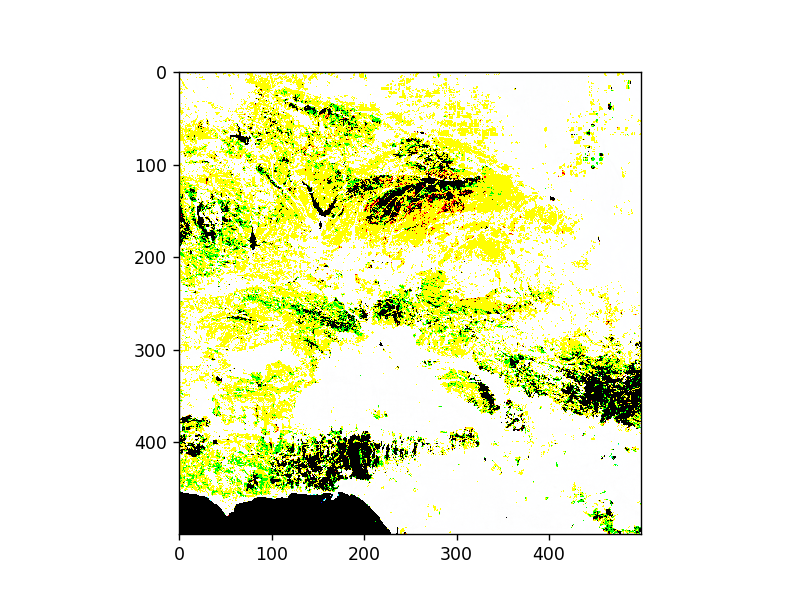

In [ ]:
out= newdata*255
plt.imshow(out.astype('uint8'), interpolation='nearest')
plt.show()

In [ ]:
plt.savefig('result.png')